# Benchmarking CUDA-Accelerated Image Processing for Annota3D: Harpia vs. cuCIM and scikit-image

This notebook analyzes experimental data from a benchmarking study of the Harpia module, a CUDA-based image processing library developed for the **Annota3D** web application. Annota3D is used to segment massive volumetric datasets acquired at Sirius, a synchrotron light source facility.

The benchmark focuses on measuring and comparing execution time and GPU memory usage across a variety of operations implemented in Harpia, including:

- Filters
- Morphological operations
- Thresholding algorithms

The performance of **Harpia** is evaluated against two widely used frameworks: **scikit-image** (CPU-based) and **cuCIM** (GPU-accelerated). The notebook processes and visualizes the benchmark results, generating comparative plots and formatted summary tables to assess the efficiency and scalability of each framework.

## Framework

In [36]:
import os
import glob
import numpy as np
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def read_csv_files(path):
    # Get the current working directory
    print("Searching in:", path)

    # Recursively find all CSV files in subdirectories
    csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)

    if not csv_files:
        print("No CSV files found.")
        return None

    # Read all CSV files into a list of DataFrames
    dfs = [pd.read_csv(file) for file in csv_files]

    # Optionally, concatenate all DataFrames into one
    df_all = pd.concat(dfs, ignore_index=True)

    print(f"Loaded {len(csv_files)} CSV files.")
    return df_all


In [37]:
def filter_dataframe(df, filters):
    """
    Filters the DataFrame based on the specified filters.

    Parameters:
    - df (pd.DataFrame): The DataFrame to filter.
    - filters (dict): A dictionary where the key is the column name and the value is the value to filter by.

    Returns:
    - pd.DataFrame: The filtered DataFrame (original remains unchanged).
    """
    filtered_df = df.copy()
    for col, value in filters.items():
        filtered_df = filtered_df[filtered_df[col] == value]
    return filtered_df


In [38]:
def save_df_as_image(df, filename='df_image.png', dpi=300, show_index=True):
    """
    Saves a DataFrame as a well-formatted image file.

    Parameters:
    - df (pd.DataFrame): The DataFrame to save.
    - filename (str): The output filename (PNG).
    - dpi (int): Resolution in dots per inch.
    - show_index (bool): Whether to display the index in the image. Default is True.
    """
   # Create a copy to avoid modifying the original DataFrame
    display_df = df.copy()
    
    # If the index should not be displayed, remove it
    if not show_index:
        display_df.index = [''] * len(display_df)
    
    # Determine the figure size based on DataFrame dimensions
    fig_width = min(20, max(6, 0.2 * display_df.shape[1]))  # Scale width by number of columns
    fig_height = min(40, max(4, 0.4 * display_df.shape[0])) # Scale height by number of rows
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('off')  # Hide the axis
    mpl_table = table(ax, display_df, loc='center', cellLoc='center', colWidths=[0.2]*len(display_df.columns))
    
    # Formatting for better readability
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(10)
    mpl_table.auto_set_column_width(col=list(range(len(display_df.columns))))  # Auto-adjust column width
    
    # Remove extra padding around the table
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # Get the bounding box of the table and adjust the figure size
    renderer = fig.canvas.get_renderer()
    bbox = mpl_table.get_window_extent(renderer=renderer)
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    
    # Save the image, tightly cropped to the table's exact size
    output_path = filename
    plt.savefig(output_path, bbox_inches=bbox, pad_inches=0, dpi=dpi)
    plt.close(fig)
    print(output_path)
    return output_path

In [39]:
def clean_framework_df(df, framework_name, min_input_size=1, min_input_mem=1000):
    # Base columns common to all
    base_cols = ['Operation', 'Machine', 'Gpus', 'gpuMemory', 'Repetitions',
                 'Image Data Type', 'Image Size (MiB)', 'Image Dimensions']

    # Framework-specific time and GPU memory columns
    time_col_map = {
        'skimage': 'Scikit Time (s)',
        'harpia': 'Harpia Time (s)',
        'cucim': 'Cucim Total Time (s)'
    }

    gpu_cols_map = {
        'skimage': ['skimage_gpu0(MiB)', 'skimage_gpu1(MiB)', 'skimage_gpu2(MiB)'],
        'harpia':  ['harpia_gpu0(MiB)', 'harpia_gpu1(MiB)', 'harpia_gpu2(MiB)'],
        'cucim':   ['cucim_gpu0(MiB)',  'cucim_gpu1(MiB)',  'cucim_gpu2(MiB)']
    }

    # Always select time column
    selected_cols = base_cols + [time_col_map[framework_name]] + gpu_cols_map[framework_name]

    df_clean = df[selected_cols].copy()

    # Rename time column
    df_clean.rename(columns={time_col_map[framework_name]: 'Total Time (s)'}, inplace=True)

    # Rename GPU0 to GPU Before
    df_clean.rename(columns={gpu_cols_map[framework_name][0]: 'GPU Before (MiB)'}, inplace=True)

    # Calculate GPU Max from GPU1 and GPU2
    gpu1_col = gpu_cols_map[framework_name][1]
    gpu2_col = gpu_cols_map[framework_name][2]
    df_clean['GPU Max (MiB)'] = df_clean[gpu1_col].combine(df_clean[gpu2_col], func=max)

    # Drop original GPU1 and GPU2 columns
    df_clean.drop(columns=[gpu1_col, gpu2_col], inplace=True)

    # Set GPU memory columns to NaN if framework is skimage or image size <= 1000
    df_clean['Image Size (MiB)'] = pd.to_numeric(
        df_clean['Image Size (MiB)'], errors='coerce'
    )
    memory_mask = (framework_name == 'skimage') | (df_clean['Image Size (MiB)'] <= min_input_mem)
    df_clean.loc[memory_mask, ['GPU Before (MiB)', 'GPU Max (MiB)']] = float('nan')

    # Drop rows where all performance metrics are NaN
    df_clean.dropna(
        subset=['Total Time (s)', 'GPU Before (MiB)', 'GPU Max (MiB)'],
        how='all',
        inplace=True
    )

    # Drop rows with image size ≤ min_input_size
    df_clean = df_clean[df_clean['Image Size (MiB)'] > min_input_size]

    # Add framework column
    framework_name_map = {
        "harpia": "Harpia",
        "cucim": "cuCIM",
        "skimage": "scikit-image"
    }
    df_clean['Framework'] = framework_name_map[framework_name]

    df_clean['Total Time (s)'] = pd.to_numeric(df_clean['Total Time (s)'], errors='coerce')
    df_clean['GPU Before (MiB)'] = pd.to_numeric(df_clean['GPU Before (MiB)'], errors='coerce')
    df_clean['GPU Max (MiB)'] = pd.to_numeric(df_clean['GPU Max (MiB)'], errors='coerce')
    return df_clean

## Save path

In [40]:
save = True #wheter to save the plots as figures
notebook_name = "benchmark_read/Mary_results"
output_dir = f"{notebook_name}_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"Plots will be saved to: {output_dir}")

Plots will be saved to: benchmark_read/Mary_results_plots


## Read data

In [41]:
current_dir = os.getcwd()
merged_df_run1 = read_csv_files(current_dir+"/results_mary/RUN1/")
merged_df = read_csv_files(current_dir+"/results_mary/RUN3/")


Searching in: /ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/tests_python/benchmark/results_mary/RUN1/
Loaded 89 CSV files.
Searching in: /ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/tests_python/benchmark/results_mary/RUN3/
Loaded 69 CSV files.


In [42]:
df_skimage_clean = clean_framework_df(merged_df_run1, 'skimage')
df_harpia_clean = clean_framework_df(merged_df, 'harpia')
df_cucim_clean  = clean_framework_df(merged_df, 'cucim')
#usa os resultados do scikit do run1
df_all_clean = pd.concat([df_skimage_clean, df_harpia_clean, df_cucim_clean], ignore_index=True)

In [43]:
df_all_clean.to_csv("benchmark_read/Mary_results_plots/raw_data.csv", index=False)

## Mean Values by operation and input size

In [44]:
# --- Filter and group ---
group_cols = ['Operation', 'Machine', 'Gpus', 'gpuMemory', 'Image Data Type','Image Dimensions', 'Image Size (MiB)', 'Framework']
agg_cols = ['Total Time (s)', 'GPU Before (MiB)', 'GPU Max (MiB)']

# Group and aggregate
summary_df = df_all_clean.groupby(group_cols)[agg_cols].agg(['mean', 'std']).reset_index()

# Flatten multi-level columns
summary_df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in summary_df.columns]

# Calculate Max Memory
summary_df['Max Memory mean'] = summary_df[['GPU Before (MiB) mean', 'GPU Max (MiB) mean']].max(axis=1)
summary_df['Max Memory std'] = summary_df[['GPU Before (MiB) std', 'GPU Max (MiB) std']].max(axis=1)
summary_df

,Operation,Machine,Gpus,gpuMemory,Image Data Type,Image Dimensions,Image Size (MiB),Framework,Total Time (s) mean,Total Time (s) std,GPU Before (MiB) mean,GPU Before (MiB) std,GPU Max (MiB) mean,GPU Max (MiB) std,Max Memory mean,Max Memory std
0,Anisotropic Diffusion Filter 3D grayscale,mary,1,0.05,float32,"(1, 2052, 2052)",16.1,Harpia,0.035148,0.000328,NaN,NaN,NaN,NaN,NaN,NaN
1,Anisotropic Diffusion Filter 3D grayscale,mary,1,0.05,float32,"(1024, 2052, 2052)",16448.1,Harpia,46.333995,0.075069,608.0,0.0,2828.0,0.0,2828.0,0.0
2,Anisotropic Diffusion Filter 3D grayscale,mary,1,0.05,float32,"(128, 2052, 2052)",2056.0,Harpia,5.715025,0.020186,608.0,0.0,2828.0,0.0,2828.0,0.0
3,Anisotropic Diffusion Filter 3D grayscale,mary,1,0.05,float32,"(16, 2052, 2052)",257.0,Harpia,0.713118,0.001313,NaN,NaN,NaN,NaN,NaN,NaN
4,Anisotropic Diffusion Filter 3D grayscale,mary,1,0.05,float32,"(2, 2052, 2052)",32.1,Harpia,0.080936,0.000493,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,Unsharp Mask Filter 3D grayscale,mary,1,0.05,float32,"(32, 2052, 2052)",514.0,Harpia,0.839230,0.043317,NaN,NaN,NaN,NaN,NaN,NaN
583,Unsharp Mask Filter 3D grayscale,mary,1,0.05,float32,"(4, 2052, 2052)",64.3,Harpia,0.116773,0.026103,NaN,NaN,NaN,NaN,NaN,NaN
584,Unsharp Mask Filter 3D grayscale,mary,1,0.05,float32,"(512, 2052, 2052)",8224.0,Harpia,20.773628,0.055640,608.0,0.0,2766.0,0.0,2766.0,0.0
585,Unsharp Mask Filter 3D grayscale,mary,1,0.05,float32,"(64, 2052, 2052)",1028.0,Harpia,1.781118,0.007094,608.0,0.0,2670.0,0.0,2670.0,0.0


### Table: mean values by operation and input size

In [45]:

df = summary_df  # Assuming you already have this DataFrame

# --- Step 1: Normalize framework names ---
df_formatted = df.copy()
df_formatted['Framework'] = df_formatted['Framework'].str.lower()

# --- Step 2: Format mean and std columns separately ---
def format_mean(x):
    if pd.isna(x):
        return '-'
    x = float(x)
    if x < 1:
        return f"{x:.4f}"
    elif x < 10:
        return f"{x:.3f}"
    else:
        return f"{x:.2f}"

def format_std(x):
    if pd.isna(x):
        return '-'
    return f"{x:.2f}"

for col in [
    'Total Time (s) mean', 'Total Time (s) std',
    'GPU Before (MiB) mean', 'GPU Before (MiB) std',
    'Max Memory mean', 'Max Memory std'
]:
    df_formatted[col] = df_formatted[col].apply(lambda x: format_mean(x) if 'mean' in col else format_std(x))

# --- Step 3: Keep relevant columns ---
df_clean = df_formatted[[
    'Operation', 'Image Dimensions', 'Image Size (MiB)', 'Framework',
    'Total Time (s) mean', 'Total Time (s) std',
    'GPU Before (MiB) mean', 'GPU Before (MiB) std',
    'Max Memory mean', 'Max Memory std'
]]

# --- Step 4: Pivot Time mean and std ---
df_time_mean = df_clean.pivot_table(
    index=['Operation', 'Image Dimensions', 'Image Size (MiB)'],
    columns='Framework',
    values='Total Time (s) mean',
    aggfunc='first'
).add_suffix(' Time (s) Mean')

df_time_std = df_clean.pivot_table(
    index=['Operation', 'Image Dimensions', 'Image Size (MiB)'],
    columns='Framework',
    values='Total Time (s) std',
    aggfunc='first'
).add_suffix(' Time (s) Std')

# --- Step 5: Pivot Residual Memory mean and std (harpia & cucim) ---
residual_mask = df_clean['Framework'].isin(['harpia', 'cucim'])

df_res_mean = df_clean[residual_mask].pivot_table(
    index=['Operation', 'Image Dimensions', 'Image Size (MiB)'],
    columns='Framework',
    values='GPU Before (MiB) mean',
    aggfunc='first'
).add_suffix(' Residual Memory (MiB) Mean')

df_res_std = df_clean[residual_mask].pivot_table(
    index=['Operation', 'Image Dimensions', 'Image Size (MiB)'],
    columns='Framework',
    values='GPU Before (MiB) std',
    aggfunc='first'
).add_suffix(' Residual Memory (MiB) Std')

# --- Step 6: Pivot Max Memory mean and std (harpia & cucim) ---
df_max_mean = df_clean[residual_mask].pivot_table(
    index=['Operation', 'Image Dimensions', 'Image Size (MiB)'],
    columns='Framework',
    values='Max Memory mean',
    aggfunc='first'
).add_suffix(' Max Memory (MiB) Mean')

df_max_std = df_clean[residual_mask].pivot_table(
    index=['Operation', 'Image Dimensions', 'Image Size (MiB)'],
    columns='Framework',
    values='Max Memory std',
    aggfunc='first'
).add_suffix(' Max Memory (MiB) Std')

# --- Step 7: Combine all results ---
df_final = pd.concat([
    df_time_mean, df_time_std,
    df_res_mean, df_res_std,
    df_max_mean, df_max_std
], axis=1).reset_index()

# --- Step 8: Rename to pretty names (optional, already readable) ---

# --- Step 9: Clean up and save ---
df_final = df_final.fillna('-')
df_final = df_final.sort_values(by=['Operation', 'Image Size (MiB)'])

# Save to CSV
csv_filename = "execution_time_by_operation_comman_separator.csv"
csv_filename2 = "execution_time_by_operation_dot_comman_separator.csv"
csv_path = os.path.join(output_dir, csv_filename)
csv_path2 = os.path.join(output_dir, csv_filename2)
df_final.to_csv(csv_path, index=False)
df_final.to_csv(csv_path2, index=False, sep=';')

print(f"CSV saved to: {csv_path}")
df_final

CSV saved to: benchmark_read/Mary_results_plots/execution_time_by_operation_comman_separator.csv


Framework,Operation,Image Dimensions,Image Size (MiB),cucim Time (s) Mean,harpia Time (s) Mean,scikit-image Time (s) Mean,cucim Time (s) Std,harpia Time (s) Std,scikit-image Time (s) Std,cucim Residual Memory (MiB) Mean,harpia Residual Memory (MiB) Mean,cucim Residual Memory (MiB) Std,harpia Residual Memory (MiB) Std,cucim Max Memory (MiB) Mean,harpia Max Memory (MiB) Mean,cucim Max Memory (MiB) Std,harpia Max Memory (MiB) Std
0,Anisotropic Diffusion Filter 3D grayscale,"(1, 2052, 2052)",16.1,-,0.0351,-,-,0.00,-,-,-,-,-,-,-,-,-
4,Anisotropic Diffusion Filter 3D grayscale,"(2, 2052, 2052)",32.1,-,0.0809,-,-,0.00,-,-,-,-,-,-,-,-,-
8,Anisotropic Diffusion Filter 3D grayscale,"(4, 2052, 2052)",64.3,-,0.1915,-,-,0.04,-,-,-,-,-,-,-,-,-
11,Anisotropic Diffusion Filter 3D grayscale,"(8, 2052, 2052)",128.5,-,0.3577,-,-,0.01,-,-,-,-,-,-,-,-,-
3,Anisotropic Diffusion Filter 3D grayscale,"(16, 2052, 2052)",257.0,-,0.7131,-,-,0.00,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,Unsharp Mask Filter 3D grayscale,"(128, 2052, 2052)",2056.0,-,3.645,-,-,0.05,-,-,608.00,-,0.00,-,2734.00,-,0.00
251,Unsharp Mask Filter 3D grayscale,"(256, 2052, 2052)",4112.0,-,7.416,-,-,0.05,-,-,547.00,-,0.00,-,2705.00,-,0.00
254,Unsharp Mask Filter 3D grayscale,"(512, 2052, 2052)",8224.0,-,20.77,-,-,0.06,-,-,608.00,-,0.00,-,2766.00,-,0.00
247,Unsharp Mask Filter 3D grayscale,"(1024, 2052, 2052)",16448.1,-,43.52,-,-,0.10,-,-,608.00,-,0.00,-,2766.00,-,0.00


## Mean values by operations

In [46]:
# Helper: function to create pivoted time table for a given operation filter
def pivot_mean_time(df, label):
    mean_time = df.groupby(['Framework', 'Image Size (MiB)'])[['Total Time (s)']].mean().reset_index()
    pivoted = mean_time.pivot(index='Image Size (MiB)', columns='Framework', values='Total Time (s)')
    pivoted.columns = [f'{col} ({label})' for col in pivoted.columns]
    return pivoted

# Filtered data
df_binary = df_all_clean[df_all_clean['Operation'].str.contains('binary', case=False)]
df_grayscale = df_all_clean[df_all_clean['Operation'].str.contains('grayscale', case=False)]

# Pivoted time tables
pivot_all = pivot_mean_time(df_all_clean, 'All Ops')
pivot_binary = pivot_mean_time(df_binary, 'Binary')
pivot_grayscale = pivot_mean_time(df_grayscale, 'Grayscale')

# Merge all into one summary table
summary = pivot_all.join([pivot_binary, pivot_grayscale], how='outer')
summary = summary.reset_index().sort_values('Image Size (MiB)')

columns_to_drop = [
    'Harpia (Binary)',
    'Harpia (Grayscale)',
    'scikit-image (Grayscale)',
    'scikit-image (Binary)',
    'cuCIM (All Ops)',
    # Example: drop just memory
    # Add any other columns you want to exclude
]

summary = summary.drop(columns=columns_to_drop, errors='ignore')
summary = summary[['Image Size (MiB)', 'Harpia (All Ops)', 'cuCIM (Binary)', 'cuCIM (Grayscale)', 'scikit-image (All Ops)']]

# Define the filename and full path
csv_filename = "execution_time_by_input_size.csv"
csv_path = os.path.join(output_dir, csv_filename)

# Save the DataFrame
summary.to_csv(csv_path, index=False)

print(f"CSV saved to: {csv_path}")


CSV saved to: benchmark_read/Mary_results_plots/execution_time_by_input_size.csv


## Plot data

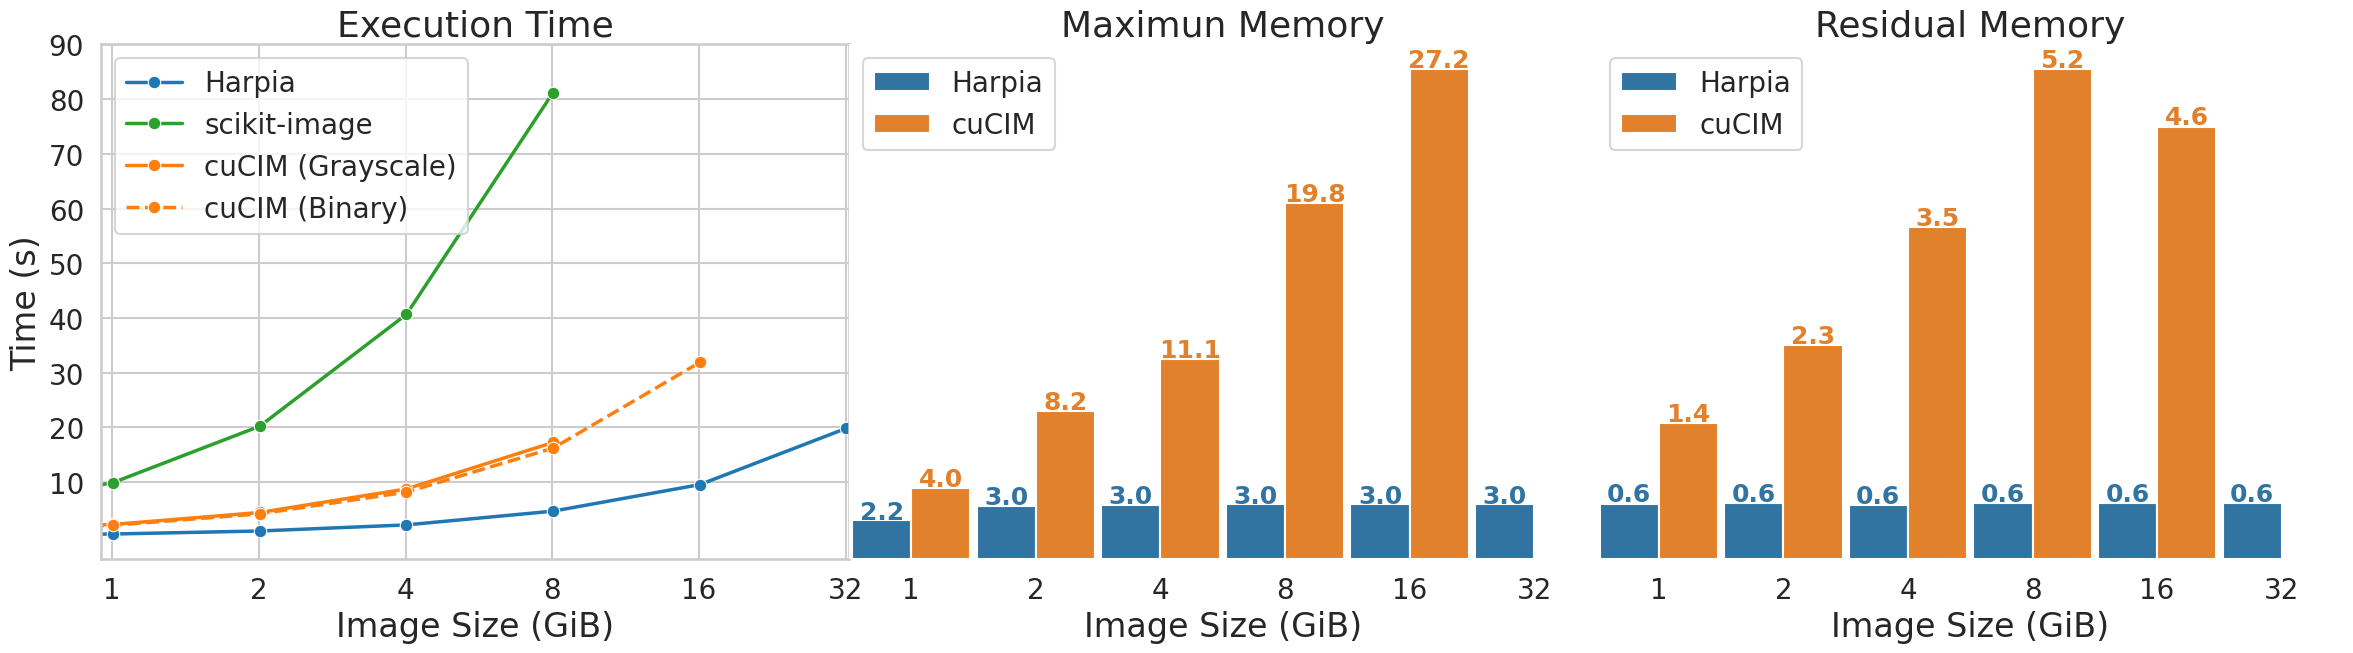

In [47]:
custom_palette = {
    'Harpia': '#1f77b4',         # Blue
    'cuCIM': '#ff7f0e',          # Orange
    'scikit-image': '#2ca02c'    # Green
}
width = 0.95

# Aggregate and convert to GiB
mem_agg = df_all_clean.groupby(['Framework', 'Image Size (MiB)'])[['GPU Max (MiB)', 'GPU Before (MiB)']].mean().reset_index()

# Convert Image Size to GiB (int)
mem_agg['Image Size (GiB)'] = (mem_agg['Image Size (MiB)'] / 1024).round().astype(int)

# Convert GPU memory columns to GiB with 2 decimals
mem_agg['GPU Max (GiB)'] = (mem_agg['GPU Max (MiB)'] / 1024).round(2)
mem_agg['GPU Before (GiB)'] = (mem_agg['GPU Before (MiB)'] / 1024).round(2)

# Filter frameworks Harpia and cucim
mem_bar = mem_agg[mem_agg['Framework'].isin(['Harpia', 'cuCIM'])]
mem_bar = mem_bar[mem_bar['Image Size (GiB)'] != 0]

# Seaborn style and font sizes
sns.set(style="whitegrid", context="talk")
plt.rcParams.update({
    'font.size': 22,
    'axes.titlesize': 26,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'legend.title_fontsize': 22
})

fig, axes = plt.subplots(1, 3, figsize=(24, 7), gridspec_kw={'width_ratios':[3, 3, 3]})
plt.subplots_adjust(wspace=0) 
# --- FIRST SUBPLOT: Your original line plot ---
ax = axes[0]
plot_df = summary.copy()
plot_df['Image Size (GiB)'] = plot_df['Image Size (MiB)'] / 1024

sns.lineplot(data=plot_df, x='Image Size (GiB)', y='Harpia (All Ops)', label='Harpia', color=custom_palette['Harpia'],
             linewidth=2.5, marker='o', ax=ax)
sns.lineplot(data=plot_df, x='Image Size (GiB)', y='scikit-image (All Ops)', label='scikit-image',  color=custom_palette['scikit-image'],
             linewidth=2.5, marker='o', ax=ax)
grayscale_line = sns.lineplot(data=plot_df, x='Image Size (GiB)', y='cuCIM (Grayscale)', color=custom_palette['cuCIM'],
                             label='cuCIM (Grayscale)', linewidth=2.5, marker='o', ax=ax)
sns.lineplot(data=plot_df, x='Image Size (GiB)', y='cuCIM (Binary)', label='cuCIM (Binary)',
             linewidth=2.5, linestyle='--', marker='o', color=custom_palette['cuCIM'], ax=ax)

ax.set_xscale("log", base=2)
ax.set_xticks([1, 2, 4, 8, 16, 32])
ax.set_xlim(0.95, 32.5)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax.set_yticks(range(10, 100, 10))

ax.set_xlabel('Image Size (GiB)', fontsize=24)
ax.set_ylabel('Time (s)', fontsize=24)
ax.set_title('Execution Time', fontsize=26)
ax.legend(title='')
ax.grid(True)

# --- SECOND SUBPLOT: GPU Max memory grouped bar plot ---
ax = axes[1]
ax.grid(False)

sns.barplot(
    data=mem_bar,
    x='Image Size (GiB)',
    y='GPU Max (MiB)',
    hue='Framework',
    ax=ax,
    palette=custom_palette,
    width = width,
)
ax.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('Image Size (GiB)', fontsize=24)
ax.set_ylabel('GPU Max Memory (MiB)', fontsize=24)
ax.set_title('Maximun Memory', fontsize=26)
ax.legend(title='')

# Add white text inside bars with 1 decimal, converted to GiB
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 500,  # slightly above the bar top
                f"{ height / 1024:.1f}",
                ha='center',
                va='center',
                color=bar.get_facecolor(),
                fontsize=18,
                fontweight='bold'
            )

# --- THIRD SUBPLOT: GPU Before memory grouped bar plot ---
ax = axes[2]
ax.grid(False)

sns.barplot(
    data=mem_bar,
    x='Image Size (GiB)',
    y='GPU Before (MiB)',
    hue='Framework',
    ax=ax,
    palette=custom_palette,
    width = width,
)
ax.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('Image Size (GiB)', fontsize=24)
ax.set_ylabel('GPU Before Memory (MiB)', fontsize=24)
ax.set_title('Residual Memory', fontsize=26)
ax.legend(title='')

# Add white text inside bars with 1 decimal, converted to GiB
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 100,  # slightly above the bar top
                f"{ height / 1024:.1f}",
                ha='center',
                va='center',
                color=bar.get_facecolor(),
                fontsize=18,
                fontweight='bold'
            )

plt.tight_layout()
plt.subplots_adjust(wspace=0)  # or your preferred spacing
# Define the filename and full path
plt.savefig(os.path.join(output_dir, "plot_execution_time_by_input_size.png"), dpi=300, bbox_inches='tight')  # or .pdf, .svg, etc.
plt.show()
